# Import modules


In [45]:
import numpy as np 
import sys
import os
from scipy import optimize
import CoolProp.CoolProp as CP
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

#Импорт модулей
from INPUT import data

# Experimental setup parameters


In [46]:
# Ускорение свободного падения
g = 9.8155  
# Диаметр трубы
d = 0.005 
# Коэффициент для расчета по Уоллису 
ki = 300
# Площадь сечения трубы
def s(d):
    return np.pi * ( d/2 )**2 

In [47]:
# Параметры для функции расчета по Фукано
V_l = CP.PropsSI('V','T',25 + 273,'P', 0.2 * 10**6,'Water')
V_w = CP.PropsSI('V','T',20 + 273,'P', 0.2 * 10**6,'Water')

# Mathematical equations


In [48]:
# Число Рейнольдса для жидкости 
def Re_liquid (liquid_density, liquid_viscosity, SV_liquid):

        # print(liquid_density, liquid_viscosity, SV_liquid)    
        return (liquid_density * SV_liquid * d)/liquid_viscosity  

def Ec(Re_liquid):
        if Re_liquid <= 2000:
                E = 64/Re_liquid
        else:
                E =  0.3164 * (Re_liquid)**(-0.25) 
        return E

In [49]:
# Диаметр межфазной поверхности 
def Di(B):      
    return  d - 2 * B  

# Истинное объемное паросодержание                                             
def Fi(B):      
    return ((d - 2 * B) / d)**2                                          
    
# Число Рейнольдса  для газообразной фазы
def RE0_gas (B, gas_density, gas_viscosity, SV_gas):       
    return (gas_density * SV_gas / Fi(B) * Di(B)) / gas_viscosity 

def E0 (Re_gas):
    return (0.3164 * (Re_gas)**(-0.25))

# Коэффициент межфазного трения Уоллиса 
def Ei(B, Re_gas):
    return  E0(Re_gas) * (1 + (ki * B) / d)

# Коэффициент межфазного трения Fukano
def Ei_Fukano (B):
    return  1.7 * (12 + ( V_l / V_w) )**(-4/3) * (1 + (12 * B) / d)**8

def Tc (B, Re_liquid, liquid_density, SV_liquid):
    return Ec(Re_liquid) * liquid_density * (SV_liquid)**2/ (8 * (1 - Fi(B))**2 )

def wb(B, liquid_density, ReL, SV_liquid, liquid_viscosity): 
    T_c = Tc(B, ReL, liquid_density, SV_liquid)
    form = (T_c / liquid_density)**0.5
    return  (2.5 * np.log( ( B * form / liquid_viscosity)) + 5.5) * form

flg_wb = True #!!!!!!!
def Ti (B, Re_gas, gas_density, SV_gas, SV_liquid, liquid_viscosity, liquid_density): 
    E_i = Ei(B, Re_gas)
    ReL = Re_liquid (liquid_density, liquid_viscosity, SV_liquid)
    if flg_wb:
        w_b = wb(B, liquid_density, ReL, SV_liquid, liquid_viscosity)
    else:
        w_b = 0
    return  E_i * gas_density * (SV_gas / Fi(B) - w_b)**2 /  8 

# Функция для расчета градиента давления 
def calcDPDZ(B, gas_density, gas_viscosity, SV_gas,SV_liquid, liquid_viscosity, liquid_density):
    ReG = RE0_gas(B, gas_density, gas_viscosity, SV_gas)
    T_i = Ti (B, ReG, gas_density, SV_gas, SV_liquid, liquid_viscosity, liquid_density)
    return 4.0 * T_i / Di(B) + gas_density * g

In [50]:
# Функция по которой считается толщина пленки 
def equation(B, liquid_density, liquid_viscosity, gas_density, gas_viscosity, delta_density, SV_liquid, SV_gas): 
    ReL = Re_liquid(liquid_density, liquid_viscosity, SV_liquid)
    ReG = RE0_gas(B, gas_density, gas_viscosity, SV_gas)
    LHS = Tc(B, ReL, liquid_density, SV_liquid)
    RHS = Ti(B, ReG, gas_density, SV_gas, SV_liquid, liquid_viscosity, liquid_density) + delta_density * g * B  
    return LHS - RHS

# Функция для расчета толщины пленки 
def calcOnePoint(args):
    sol = optimize.root_scalar(equation,
                               args=args,
                               bracket=[1.0e-13, d/2-1.0e-13], method='brentq')
    return sol.root

In [51]:
def find_error(n, a, b):
    erOr = 0
    k = 0   # для 15%
    t = 0   # для 30%
    for i in range(len(a)): 
        sum = abs(a[i] - b[i]) / a[i]
        erOr += sum
        if sum <= 0.15:
            k += 1
        elif sum <= 0.3:
            t += 1
    erOr = 100 * erOr / n
    return [erOr, t + k, k, len(a)]

def find_error2(n, a, b):
    erOr = 0
    k = 0   
    t = 0
    for i in range(len(a)): 
        sum = (a[i] - b[i]) / a[i]
        erOr += sum
        if -0.15 <= sum <= 0.15:
            k +=1
        elif -0.3 <= sum <= 0.3:
            t += 1
    erOr =  100 * erOr / n
    return [erOr, t + k, k]
       

In [52]:
def calculate(param):
     liquid_d = param['Liquid density']
     liquid_v = param['Liquid viscosity']
     gas_d = param['Gas density']
     gas_v = param['Gas viscosity']
     SV_liquid = param['Liquid velocity'] 
     SV_gas = param['Gas velocity']
     delta_d = param['Delta density'] 
     sub = param['Substance']


     params = (liquid_d, liquid_v, gas_d, gas_v, delta_d, SV_liquid, SV_gas)

     # Расчет толщины пленки
     B = calcOnePoint(params) 
     
     # Расчет градиента давления
     dpdz = calcDPDZ(B=B, gas_density=gas_d, gas_viscosity=gas_v, SV_gas=SV_gas, SV_liquid=SV_liquid, liquid_viscosity=liquid_v, liquid_density=liquid_d)  
     
     ReL = Re_liquid(liquid_d, liquid_v, SV_liquid)
     ReG = RE0_gas(B, gas_d, gas_v, SV_gas)
     
     if flg_wb:
          w_b = wb(B, liquid_d, ReL, SV_liquid, liquid_v)
     else:
          w_b = 0

     Res = [SV_gas, SV_liquid, B, dpdz, sub, ReL, ReG, w_b]

     return Res

# Первая статья


# Import experimental dataset


In [53]:
rows = []
for substance, params in data.items():
    for velocity, (w_gas_list, grad_list) in params['Velocity'].items():
        min_length = min(len(w_gas_list), len(grad_list))
        for i in range(min_length):
            rows.append({
                'Substance': substance,
                'Liquid velocity': velocity,  
                'Gas velocity': w_gas_list[i],  
                'dp/dz': grad_list[i] * 10**3,  
                'Pressure': params['Pressure'],
                'Temperature': params['Temperature'],
                'Liquid density': params['liquid_density'],
                'Gas density': params['gas_density'],
                'Liquid viscosity': params['liquid_viscosity'],
                'Gas viscosity': params['gas_viscosity']
            })
exp_df = pd.DataFrame(rows)
exp_df['Difference'] = exp_df['Liquid density'] - exp_df['Gas density']
exp_df

,Substance,Liquid velocity,Gas velocity,dp/dz,Pressure,Temperature,Liquid density,Gas density,Liquid viscosity,Gas viscosity,Difference
0,Nitrogen-Water_02,0.1,12.819001,20945.945946,200000.0,25,997,2.3,0.00085,0.000018,994.7
1,Nitrogen-Water_02,0.1,15.256347,22747.747748,200000.0,25,997,2.3,0.00085,0.000018,994.7
2,Nitrogen-Water_02,0.1,21.045045,27027.027027,200000.0,25,997,2.3,0.00085,0.000018,994.7
3,Nitrogen-Water_02,0.1,25.678952,30855.855856,200000.0,25,997,2.3,0.00085,0.000018,994.7
4,Nitrogen-Water_02,0.1,30.620803,35360.360360,200000.0,25,997,2.3,0.00085,0.000018,994.7
...,...,...,...,...,...,...,...,...,...,...,...
90,Nitrogen-95Ethanol,0.8,30.563473,69144.144144,200000.0,25,850,2.3,0.00142,0.000008,847.7
91,Nitrogen-95Ethanol,0.8,31.657658,69594.594595,200000.0,25,850,2.3,0.00142,0.000008,847.7
92,Nitrogen-95Ethanol,0.8,36.673219,75900.900901,200000.0,25,850,2.3,0.00142,0.000008,847.7
93,Nitrogen-95Ethanol,0.8,37.952498,76801.801802,200000.0,25,850,2.3,0.00142,0.000008,847.7


# Create substance prorerties dataset


In [54]:
main_data = {
      'Nitrogen-Water_02': {
            'Liquid density': 997,
            'Liquid viscosity': 850 * 10**(-6),
            'Gas density': 2.3, 
            'Gas viscosity': 17.7 * 10**(-6), 
      },                
      
      'Nitrogen-Water_04': {
            'Liquid density': 997,
            'Liquid viscosity': 850 * 10**(-6), 
            'Gas density': 4.5, 
            'Gas viscosity': 17.7 * 10**(-6) 
      }, 
   
      'HFC134a-Water' : {
            'Liquid density': 992,
            'Liquid viscosity': 850 * 10**(-6),
            'Gas density': 31.5, 
            'Gas viscosity': 12.3 * 10**(-6), 
      }, 
    
      'Nitrogen-95Ethanol': {
            'Liquid density': 850,
            'Liquid viscosity': 1420 * 10**(-6), 
            'Gas density': 2.3, 
            'Gas viscosity': 7.7 * 10**(-6), 
      }
}

In [55]:
df = pd.DataFrame(main_data)
df = df.T
df['Delta density'] = df['Liquid density'] - df['Gas density']
df

,Liquid density,Liquid viscosity,Gas density,Gas viscosity,Delta density
Nitrogen-Water_02,997.0,0.00085,2.3,0.000018,994.7
Nitrogen-Water_04,997.0,0.00085,4.5,0.000018,992.5
HFC134a-Water,992.0,0.00085,31.5,0.000012,960.5
Nitrogen-95Ethanol,850.0,0.00142,2.3,0.000008,847.7


# Main computation loop


In [56]:
substances = ['Nitrogen-Water_02', 'Nitrogen-Water_04', 'HFC134a-Water', 'Nitrogen-95Ethanol']
liquid_velocity = [0.1, 0.4, 0.8]
gas_velocity = [i for i in range(5, 55, 5)]
result = []
result_without_wb = []

for substance in substances:
    for liquidV in liquid_velocity:
        for gasV in gas_velocity: 

            df_dict = df.loc[substance].to_dict()
            df_dict['Liquid velocity'] = liquidV
            df_dict['Gas velocity'] = gasV
            df_dict['Substance'] = substance
            flg_wb = True
            res = calculate(df_dict)
            result.append(res)
            flg_wb = False
            result_without_wb.append(calculate(df_dict))
                     
result_df = pd.DataFrame(result, columns=['Gas velocity', 'Liquid velocity', 'b', 'dp/dz', 'Substance', 'Re Liquid', 'Re Gas', 'Wb'])
result_df_without_wb = pd.DataFrame(result_without_wb, columns=['Gas velocity', 'Liquid velocity', 'b', 'dp/dz', 'Substance', 'Re Liquid', 'Re Gas', 'Wb'])

In [57]:
result_df.sort_values(['Substance', 'Liquid velocity', 'Gas velocity',], ascending=[True, True, True])
result_df = result_df[['Substance', 'Liquid velocity', 'Gas velocity', 'b', 'dp/dz', 'Re Liquid', 'Re Gas', 'Wb']]
result_df

,Substance,Liquid velocity,Gas velocity,b,dp/dz,Re Liquid,Re Gas,Wb
0,Nitrogen-Water_02,0.1,5,0.000180,4620.711201,586.470588,3500.023632,-0.385268
1,Nitrogen-Water_02,0.1,10,0.000130,10119.253959,586.470588,6853.851076,-0.529376
2,Nitrogen-Water_02,0.1,15,0.000105,15971.407234,586.470588,10172.874893,-0.654612
3,Nitrogen-Water_02,0.1,20,0.000089,22154.170108,586.470588,13476.416281,-0.767220
4,Nitrogen-Water_02,0.1,25,0.000079,28640.738089,586.470588,16770.887237,-0.870926
...,...,...,...,...,...,...,...,...
115,Nitrogen-95Ethanol,0.8,30,0.000214,98712.775540,2394.366197,48998.478549,-0.637600
116,Nitrogen-95Ethanol,0.8,35,0.000197,115310.629475,2394.366197,56740.368875,-0.694079
117,Nitrogen-95Ethanol,0.8,40,0.000183,132181.589909,2394.366197,64458.389473,-0.747553
118,Nitrogen-95Ethanol,0.8,45,0.000171,149316.825937,2394.366197,72157.259538,-0.798533


In [58]:
result_df_without_wb.sort_values(['Substance', 'Liquid velocity', 'Gas velocity',], ascending=[True, True, True])
result_df_without_wb = result_df_without_wb[['Substance', 'Liquid velocity', 'Gas velocity', 'b', 'dp/dz', 'Re Liquid', 'Re Gas', 'Wb']]
result_df_without_wb.to_excel(r'C:\Users\andre\res.xlsx')

# Plotting graths


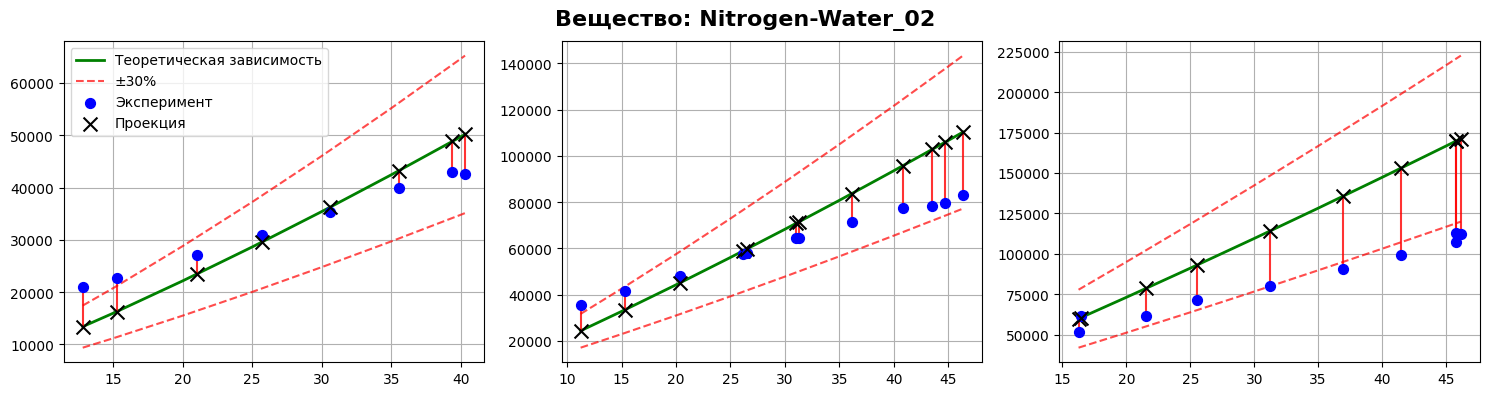

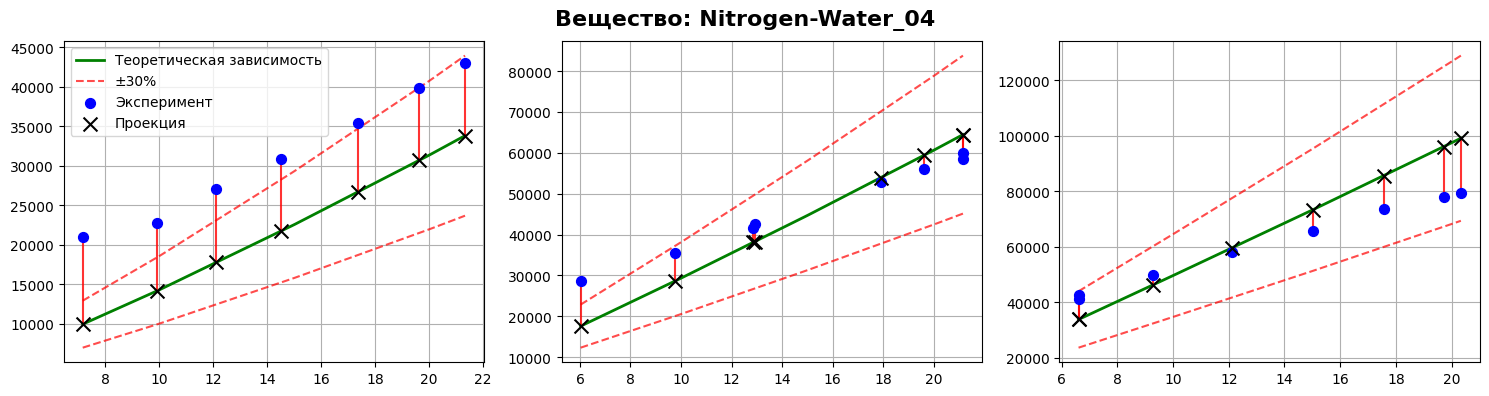

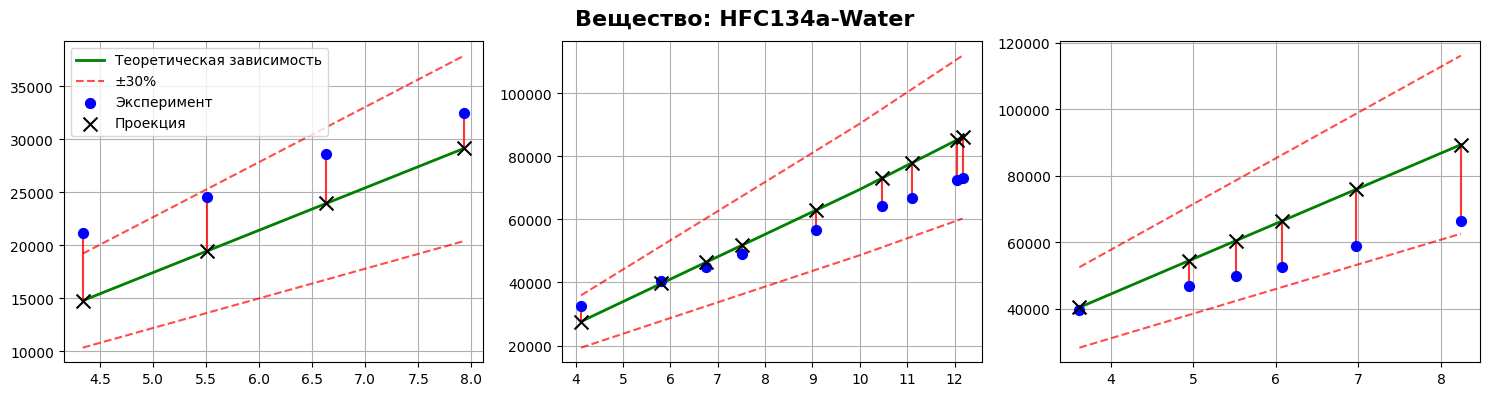

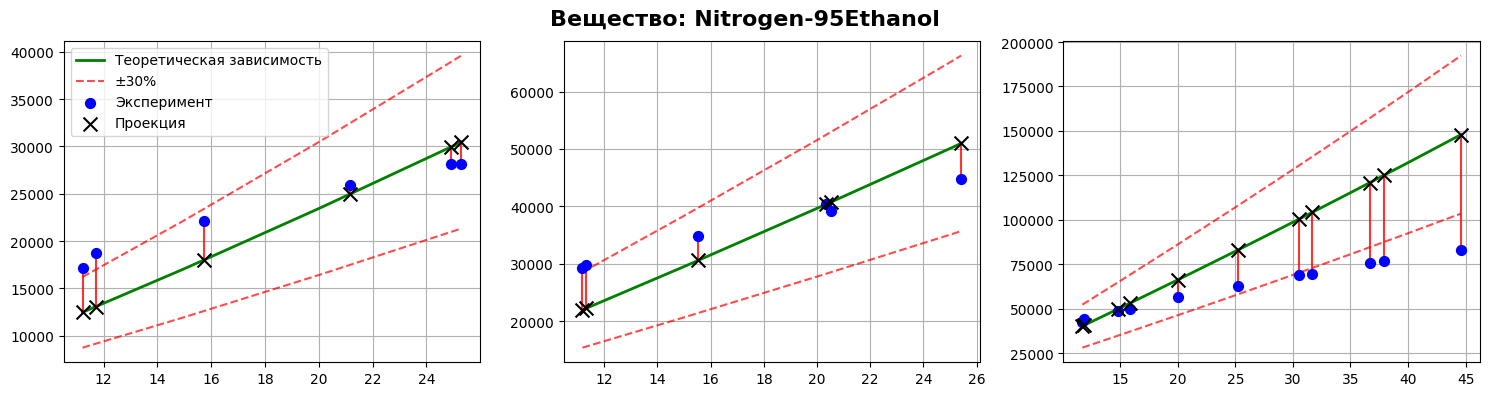

In [59]:
# Получаем уникальные вещества
unique_substances = result_df['Substance'].unique()

for sub in unique_substances:
    # Получаем все скорости жидкости для текущего вещества
    sub_liquid_velocities = result_df[result_df['Substance'] == sub]['Liquid velocity'].unique()
    
    # Определяем количество графиков для этого вещества
    n_plots = len(sub_liquid_velocities)
    
    # Пропускаем вещество, если нет данных
    if n_plots == 0:
        continue
    
    # Создаем сетку subplots (максимум 3 в строке)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols  # Округление вверх
    
    # Создаем фигуру с subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    fig.suptitle(f'Вещество: {sub}', fontsize=16, fontweight='bold')
    
    # Преобразуем axes в массив для единообразия обработки
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(-1)
    else:
        axes = axes.flatten()
    
    # Проходим по каждой скорости жидкости для этого вещества
    for idx, liquid in enumerate(sub_liquid_velocities):
        # Получаем текущий ax
        ax = axes[idx]
        
        # Фильтрация данных
        condition = (result_df['Substance'] == sub) & (result_df['Liquid velocity'] == liquid)
        x = result_df[condition]['Gas velocity']
        y = result_df[condition]['dp/dz']
        
        exp_condition = (exp_df['Substance'] == sub) & (exp_df['Liquid velocity'] == liquid)
        x_exp = exp_df[exp_condition]['Gas velocity']
        y_exp = exp_df[exp_condition]['dp/dz']

            
        # Создание интерполяционной функции для теоретической кривой
        interp_func = interpolate.interp1d(x, y, bounds_error=False, fill_value="extrapolate")
        
        # Основная теоретическая кривая (только в области экспериментальных точек)
        x_min, x_max = min(x_exp), max(x_exp)
        x_theory_range = np.linspace(x_min, x_max, 100)
        y_theory_range = interp_func(x_theory_range)
        
        ax.plot(x_theory_range, y_theory_range, color="green", label="Теоретическая зависимость", linewidth=2)
        
        # Полосы ±30% (только в области экспериментальных точек)
        ax.plot(x_theory_range, 1.3 * y_theory_range, color="red", label="±30%", linestyle="--", alpha=0.7) 
        ax.plot(x_theory_range, 0.7 * y_theory_range, color="red", linestyle="--", alpha=0.7)

        # Проекция экспериментальных точек и соединение линиями
        projected_points = []
        for xe, ye in zip(x_exp, y_exp):
            ye_proj = interp_func(xe)  # Проекция на теоретическую кривую
            
            # Экспериментальная точка (синяя)
            ax.scatter(xe, ye, color='blue', s=50, zorder=5, label='Эксперимент' if not projected_points else "")
            
            # Спроецированная точка (черная)
            ax.scatter(xe, ye_proj, color='black', marker='x', s=100, zorder=5, label='Проекция' if not projected_points else "")
            
            # Проекционная линия (ярко-красная)
            ax.plot([xe, xe], [ye, ye_proj], color='red', linestyle='-', linewidth=1.5, alpha=0.8)
            
            projected_points.append((xe, ye_proj))
       
        
        # Добавляем легенду только к первому subplot
        if idx == 0:
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), loc='best')
        

        ax.grid()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Оставляем место для общего заголовка
    # plt.show()

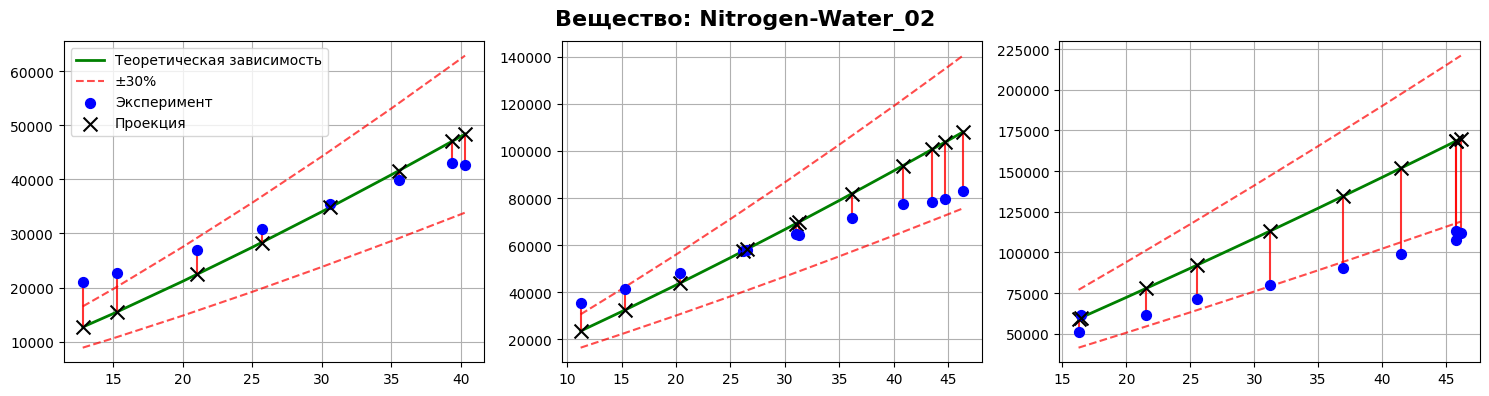

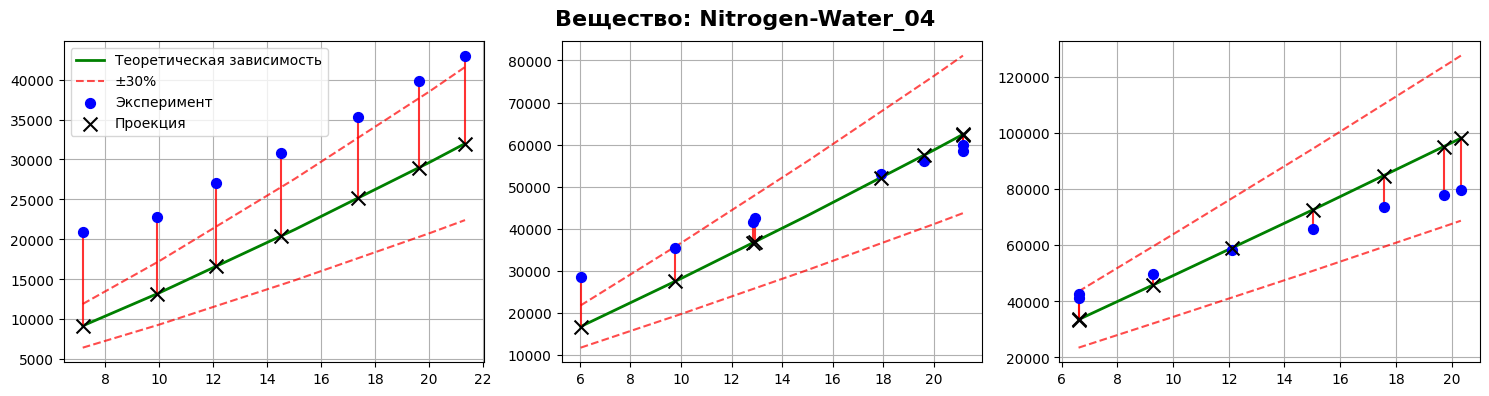

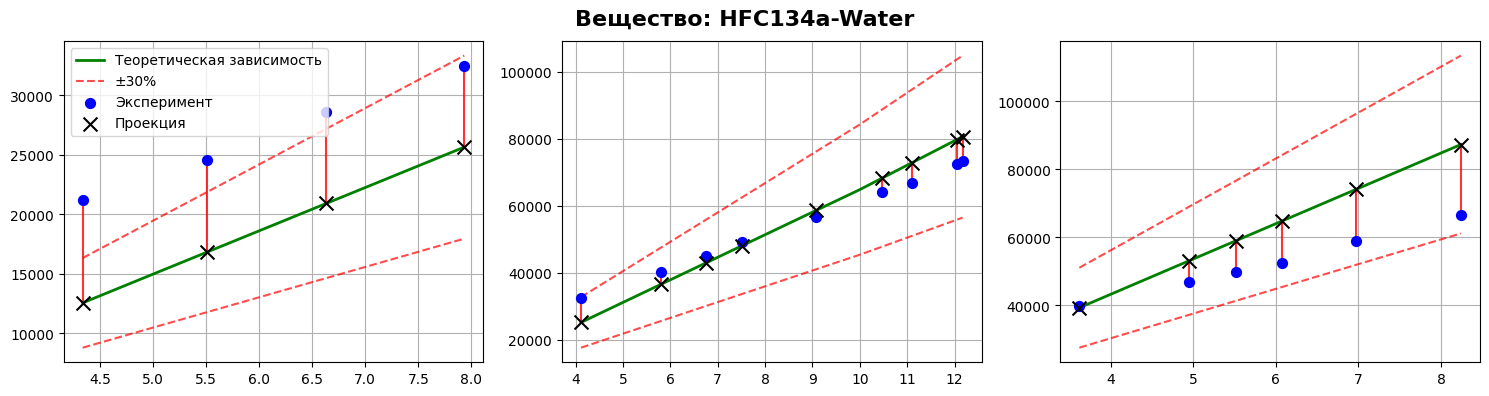

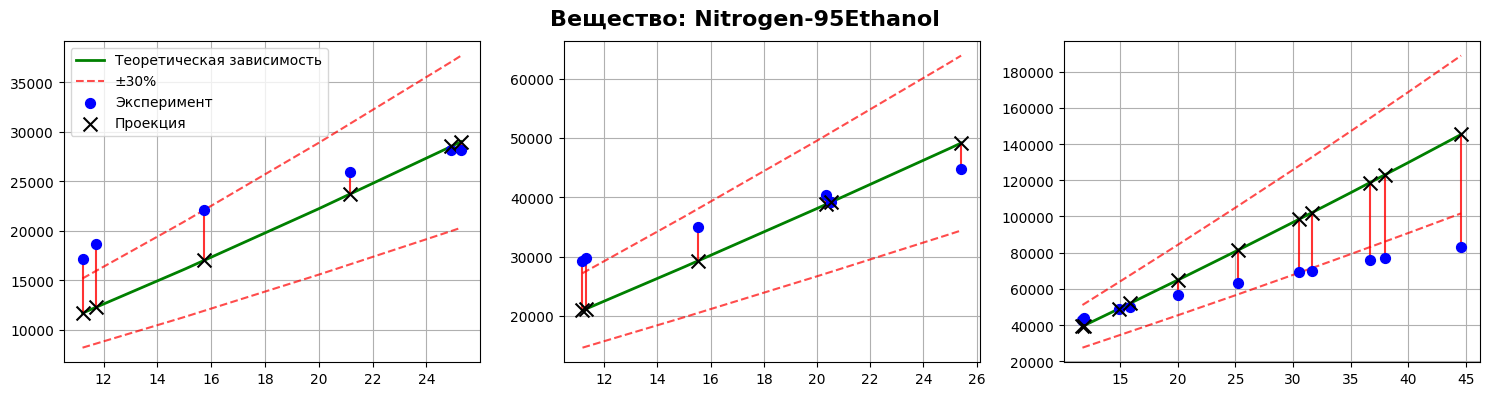

In [60]:
# Получаем уникальные вещества
unique_substances = result_df_without_wb['Substance'].unique()

for sub in unique_substances:
    # Получаем все скорости жидкости для текущего вещества
    sub_liquid_velocities = result_df_without_wb[result_df['Substance'] == sub]['Liquid velocity'].unique()
    
    # Определяем количество графиков для этого вещества
    n_plots = len(sub_liquid_velocities)
    
    # Пропускаем вещество, если нет данных
    if n_plots == 0:
        continue
    
    # Создаем сетку subplots (максимум 3 в строке)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols  # Округление вверх
    
    # Создаем фигуру с subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    fig.suptitle(f'Вещество: {sub}', fontsize=16, fontweight='bold')
    
    # Преобразуем axes в массив для единообразия обработки
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(-1)
    else:
        axes = axes.flatten()
    
    # Проходим по каждой скорости жидкости для этого вещества
    for idx, liquid in enumerate(sub_liquid_velocities):
        # Получаем текущий ax
        ax = axes[idx]
        
        # Фильтрация данных
        condition = (result_df_without_wb['Substance'] == sub) & (result_df_without_wb['Liquid velocity'] == liquid)
        x = result_df_without_wb[condition]['Gas velocity']
        y = result_df_without_wb[condition]['dp/dz']
        
        exp_condition = (exp_df['Substance'] == sub) & (exp_df['Liquid velocity'] == liquid)
        x_exp = exp_df[exp_condition]['Gas velocity']
        y_exp = exp_df[exp_condition]['dp/dz']

            
        # Создание интерполяционной функции для теоретической кривой
        interp_func = interpolate.interp1d(x, y, bounds_error=False, fill_value="extrapolate")
        
        # Основная теоретическая кривая (только в области экспериментальных точек)
        x_min, x_max = min(x_exp), max(x_exp)
        x_theory_range = np.linspace(x_min, x_max, 100)
        y_theory_range = interp_func(x_theory_range)
        
        ax.plot(x_theory_range, y_theory_range, color="green", label="Теоретическая зависимость", linewidth=2)
        
        # Полосы ±30% (только в области экспериментальных точек)
        ax.plot(x_theory_range, 1.3 * y_theory_range, color="red", label="±30%", linestyle="--", alpha=0.7) 
        ax.plot(x_theory_range, 0.7 * y_theory_range, color="red", linestyle="--", alpha=0.7)

        # Проекция экспериментальных точек и соединение линиями
        projected_points = []
        for xe, ye in zip(x_exp, y_exp):
            ye_proj = interp_func(xe)  # Проекция на теоретическую кривую
            
            # Экспериментальная точка (синяя)
            ax.scatter(xe, ye, color='blue', s=50, zorder=5, label='Эксперимент' if not projected_points else "")
            
            # Спроецированная точка (черная)
            ax.scatter(xe, ye_proj, color='black', marker='x', s=100, zorder=5, label='Проекция' if not projected_points else "")
            
            # Проекционная линия (ярко-красная)
            ax.plot([xe, xe], [ye, ye_proj], color='red', linestyle='-', linewidth=1.5, alpha=0.8)
            
            projected_points.append((xe, ye_proj))
       
        
        # Добавляем легенду только к первому subplot
        if idx == 0:
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), loc='best')
        

        ax.grid()

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Оставляем место для общего заголовка
    plt.show()

# Вторая статья


In [61]:
# Характеристики CO2
V = [i for i in range(300, 700, 100)] # Массовый расход  
T = -10 # Температура 
d = 1.42 * 10**(-3) # Диаметр канала 
q = 29.5 * 10**3
x_liquid = 0 
x_gas = 1
x = np.array([round(i * 0.1,2) for i in range(1, 10)])

In [62]:
def phase_velocity(G, x, fluid, P=None, T=None):
    """
    Расчет расходных скоростей фаз из массовой скорости
    с поддержкой векторных вычислений для меняющегося паросодержания
    
    Parameters:
    G - массовая скорость [kg/m²s] (скаляр или массив)
    x - паросодержание [0-1] (скаляр или массив)
    fluid - рабочее вещество
    P - давление [Pa] (обязательно если не задана T)
    T - температура [K] (обязательно если не задана P)
    """
    
    # Получаем плотности фаз (константы для заданных P,T)
    if P is not None:
        # Используем давление как входной параметр
        rho_l = CP.PropsSI('D', 'P', P, 'Q', 0, fluid)  # Плотность жидкости
        rho_g = CP.PropsSI('D', 'P', P, 'Q', 1, fluid)  # Плотность пара
        viscosity_liquid = CP.PropsSI('VISCOSITY', 'P', P, 'Q', 0, 'CO2') # Вязкость жидкости
        viscosity_gas = CP.PropsSI('VISCOSITY', 'P', P, 'Q', 1, 'CO2') # Вязкость пара

    elif T is not None:
        # Используем температуру как входной параметр 
        viscosity_liquid = CP.PropsSI('VISCOSITY','T', T,'Q', 0,'CO2') # Вязкость жидкости
        viscosity_gas = CP.PropsSI('VISCOSITY','T',T,'Q', 1,'CO2') # Вязкость пара
        rho_l = CP.PropsSI('D', 'T', T, 'Q', 0, fluid)
        rho_g = CP.PropsSI('D', 'T', T, 'Q', 1, fluid)

    else:
        raise ValueError("Необходимо задать либо P, либо T")
    
    # Преобразуем входные данные в массивы numpy для векторных операций
    G_array = np.asarray(G)
    x_array = np.asarray(x)
    
    # Проверка совместимости размеров
    if G_array.ndim > 0 and x_array.ndim > 0 and G_array.shape != x_array.shape:
        # Если оба массива и размеры не совпадают, пытаемся сделать бродкастинг
        try:
            # Проверяем возможность бродкастинга
            np.broadcast_arrays(G_array, x_array)
        except ValueError:
            raise ValueError("Размеры массивов G и x должны быть совместимы для бродкастинга")
    
    # Расчет расходных скоростей (векторные операции)
    j_l = G_array * (1 - x_array) / rho_l  # Скорость жидкости [m/s]
    j_g = G_array * x_array / rho_g        # Скорость пара [m/s]
    
    return {
        'x': x,
        'liquid_viscosity': viscosity_liquid,
        'liquid_density': rho_l,
        'gas_viscosity': viscosity_gas,
        'gas_density': rho_g,
        'liquid_velocity': j_l,
        'vapor_velocity': j_g,
    }

values = []

for G in V:
    for j in range(len(x)):
        params = phase_velocity(G=G, x=x[j], fluid="CO2", T=263)
        values.append({
                'G': G,
                'x': params['x'],
                'Liquid viscosity': params['liquid_viscosity'],
                'Liquid density': params['liquid_density'],
                'Gas viscosity': params['gas_viscosity'],
                'Gas density': params['gas_density'],
                'Liquid velocity': params['liquid_velocity'],
                'Gas velocity': params['vapor_velocity']
            })


In [63]:
df = pd.DataFrame(values, columns=['G', 'x', 'Liquid viscosity', 'Liquid density', 'Gas viscosity', 'Gas density', 'Liquid velocity', 'Gas velocity'])
df['Delta density'] = df['Liquid density'] - df['Gas density']
df['Substance'] = 'CO2'
df.to_csv(r'C:\Users\andre\OneDrive\Desktop\MPEI\NIR\Python\res.txt', sep='\t')
df[:4]

,G,x,Liquid viscosity,Liquid density,Gas viscosity,Gas density,Liquid velocity,Gas velocity,Delta density,Substance
0,300,0.1,0.000119,983.702537,0.000014,70.847759,0.274473,0.423443,912.854778,CO2
1,300,0.2,0.000119,983.702537,0.000014,70.847759,0.243976,0.846886,912.854778,CO2
2,300,0.3,0.000119,983.702537,0.000014,70.847759,0.213479,1.270330,912.854778,CO2
3,300,0.4,0.000119,983.702537,0.000014,70.847759,0.182982,1.693773,912.854778,CO2


In [64]:
res = df.to_dict(orient='records')
result = []
result_without_wb = []

for i in res:
    flg_wb = True
    func = calculate(i) 
    func = func + [i['x']]
    result.append(func)

    flg_wb = False
    func = calculate(i)
    func = func = func + [i['x']]
    result_without_wb.append(func)
                     
result_df = pd.DataFrame(result, columns=['Gas velocity', 'Liquid velocity', 'b', 'dp/dz', 'Substance', 'Re Liquid', 'Re Gas', 'Wb', 'x'])
result_df_without_wb = pd.DataFrame(result_without_wb, columns=['Gas velocity', 'Liquid velocity', 'b', 'dp/dz', 'Substance', 'Re Liquid', 'Re Gas', 'Wb', 'x'])

In [65]:
result_df[:10]

,Gas velocity,Liquid velocity,b,dp/dz,Substance,Re Liquid,Re Gas,Wb,x
0,0.423443,0.274473,0.000107,13987.870190,CO2,3219.269730,3678.490072,-0.097124,0.1
1,0.846886,0.243976,0.000074,24123.298893,CO2,2861.573093,6969.395696,-0.153245,0.2
2,1.270330,0.213479,0.000056,32636.005596,CO2,2503.876456,10165.343611,-0.212337,0.3
3,1.693773,0.182982,0.000044,39620.622395,CO2,2146.179820,13308.146256,-0.276419,0.4
4,2.117216,0.152485,0.000031,40847.257474,CO2,1788.483183,16323.587062,-0.377869,0.5
5,2.540659,0.121988,0.000026,46210.510912,CO2,1430.786546,19442.202738,-0.439248,0.6
6,2.964102,0.091491,0.000022,50075.855700,CO2,1073.089910,22534.677192,-0.506798,0.7
7,3.387545,0.060994,0.000017,51637.483830,CO2,715.393273,25593.722941,-0.584904,0.8
8,3.810989,0.030497,0.000012,48862.750651,CO2,357.696637,28595.914397,-0.684828,0.9
9,0.564591,0.365964,0.000115,21833.875672,CO2,4292.359639,4962.459625,-0.062457,0.1


In [66]:
result_df_without_wb[:10]

,Gas velocity,Liquid velocity,b,dp/dz,Substance,Re Liquid,Re Gas,Wb,x
0,0.423443,0.274473,0.000115,11870.508039,CO2,3219.269730,3727.943665,0,0.1
1,0.846886,0.243976,0.000080,20741.186116,CO2,2861.573093,7033.910849,0,0.2
2,1.270330,0.213479,0.000061,27970.122553,CO2,2503.876456,10237.876419,0,0.3
3,1.693773,0.182982,0.000048,33700.701521,CO2,2146.179820,13385.275440,0,0.4
4,2.117216,0.152485,0.000034,33767.882048,CO2,1788.483183,16401.205087,0,0.5
5,2.540659,0.121988,0.000029,38158.931231,CO2,1430.786546,19519.264194,0,0.6
6,2.964102,0.091491,0.000024,41165.773736,CO2,1073.089910,22609.705548,0,0.7
7,3.387545,0.060994,0.000019,42074.441263,CO2,715.393273,25664.459871,0,0.8
8,3.810989,0.030497,0.000014,39121.573316,CO2,357.696637,28657.587057,0,0.9
9,0.564591,0.365964,0.000119,20227.711196,CO2,4292.359639,4999.079704,0,0.1
